In [114]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time
import cv2

import os
import math

from sklearn.metrics import classification_report

img_height = 64
img_width = 64
batch_size = 32

In [115]:
class Tile:   
    x = 0
    y = 0
    width = 0
    height = 0
    imagex = 0
    imagey = 0
    roi = 0

    def __init__(self,x, y, overlap, width, height, imagex, imagey):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
#         self.imagex = x * (width - overlap)
#         self.imagey = y * (height - overlap)
        self.imagex = imagex
        self.imagey = imagey

    def populate(self,master):
        y = self.imagey
        x = self.imagex
        height = self.height
        width = self.width
        #print(y,x)
        self.roi = master[y:y+height, x:x+width]
        if (self.roi.shape[1] < width):
            #print("error", self.roi.shape, x)
            new_x = x - (width-self.roi.shape[1])
            self.roi = master[y:y+height, new_x:new_x+width]
            self.imagex = new_x


        if (self.roi.shape[0] <height):
            #print("error", self.roi.shape)
            new_y = y - (height-self.roi.shape[0])
            self.roi = master[new_y:new_y+height, x:x+width]
            self.imagey = new_y
        

In [116]:
def tileImage(image,width, height, overlap):
    t_width = width
    t_height = height
    overlap = overlap

    # get dimensions of image
    dimensions = image.shape
 
    # height, width, number of channels in image
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]

    tilesInX = math.ceil(width / (t_width - overlap))
    tilesInY = math.ceil(height / (t_height - overlap))
    
    tiles = []

    
    for y in range(tilesInY):
        row = []
        for x in range(tilesInX):
            tempx =  x * (t_width - overlap)
            tempy = y * (t_height - overlap)
            
            if(y == tilesInY - 1):
                tempy = height - t_height
                
            if(x == tilesInX-1):
                tempx = width - t_width

                

            
            tile = Tile(x,y,overlap,t_width,t_height, tempx, tempy)
            tile.populate(image)
            row.append(tile)
        tiles.append(row)
        
    return tiles
        

In [211]:
def modelInspect(img, model):
    tiles = tileImage(img,64,64,20)
    imarray = []

    for row in tiles:
        for tile in row:
                # convert cv2 to tensor flow
            start = time.perf_counter()
            tileIm = tile.roi
            tileImRGB = cv2.cvtColor(tileIm, cv2.COLOR_BGR2RGB)

            imarray.append(tileImRGB)
 
    arg = tf.convert_to_tensor(imarray, dtype=tf.float32)
    predictions = model.predict(arg)
    indices = np.where(predictions < 0.998)
    #print(indices[0])
    if len(indices[0]) >= 1:
        return 0
    return 1
            
        
def modelInspectStrict(img, model):
    tiles = tileImage(img,64,64,20)
    imarray = []

    for row in tiles:
        for tile in row:
                # convert cv2 to tensor flow
            start = time.perf_counter()
            tileIm = tile.roi
            tileImRGB = cv2.cvtColor(tileIm, cv2.COLOR_BGR2RGB)

            imarray.append(tileImRGB)
 
    arg = tf.convert_to_tensor(imarray, dtype=tf.float32)
    predictions = model.predict(arg)
    indices = np.where(predictions < 0.15)
    #print(indices[0])
    if len(indices[0]) >= 1:
        return 0
    return 1



In [118]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='training_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 5064 files belonging to 2 classes.


In [119]:
val_ds = keras.utils.image_dataset_from_directory(
    directory='validation_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 967 files belonging to 2 classes.


In [120]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [121]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 114216 files belonging to 2 classes.


In [122]:
class_names = train_ds.class_names
print(class_names)

['defect', 'normal']


In [123]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [124]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])



In [125]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)       

In [126]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 21s 113ms/step - loss: 0.5326 - accuracy: 0.7461 - val_loss: 0.3987 - val_accuracy: 0.8449
Epoch 2/15
159/159 [==============================] - 20s 128ms/step - loss: 0.4834 - accuracy: 0.7662 - val_loss: 0.3745 - val_accuracy: 0.8263
Epoch 3/15
159/159 [==============================] - 19s 120ms/step - loss: 0.4268 - accuracy: 0.7727 - val_loss: 0.4591 - val_accuracy: 0.7187
Epoch 4/15
159/159 [==============================] - 17s 109ms/step - loss: 0.3837 - accuracy: 0.7897 - val_loss: 0.3751 - val_accuracy: 0.8449
Epoch 5/15
159/159 [==============================] - 18s 113ms/step - loss: 0.3733 - accuracy: 0.8004 - val_loss: 0.2826 - val_accuracy: 0.8242
Epoch 6/15
159/159 [==============================] - 16s 104ms/step - loss: 0.2754 - accuracy: 0.8853 - val_loss: 0.1875 - val_accuracy: 0.9431
Epoch 7/15
159/159 [==============================] - 19s 117ms/step - loss: 0.1869 - accuracy: 0.9277 - val_loss: 0.1563 - val_ac

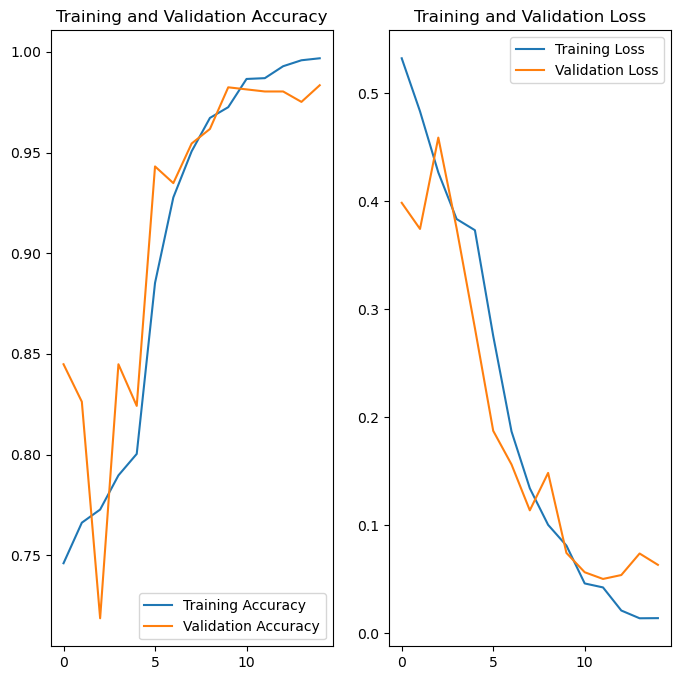

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.rcParams['font.size'] = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [133]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 1s 66ms/step - loss: 0.0574 - accuracy: 0.9894


{'loss': 0.05741988494992256, 'accuracy': 0.9893617033958435}

In [134]:
model.save("inspection_model")


INFO:tensorflow:Assets written to: inspection_model\assets


## Confusion Matrix no aug

In [184]:
model = keras.models.load_model("inspection_model")


test_ds_NoShuf = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=1,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 564 files belonging to 2 classes.


In [185]:
predictions = model.predict(test_ds_NoShuf)

OldTargets = np.concatenate([targets for features, targets in test_ds_NoShuf], axis=0)
# print(targets)
targets = []
for num in OldTargets:
    targets.append(num[0])

    
roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

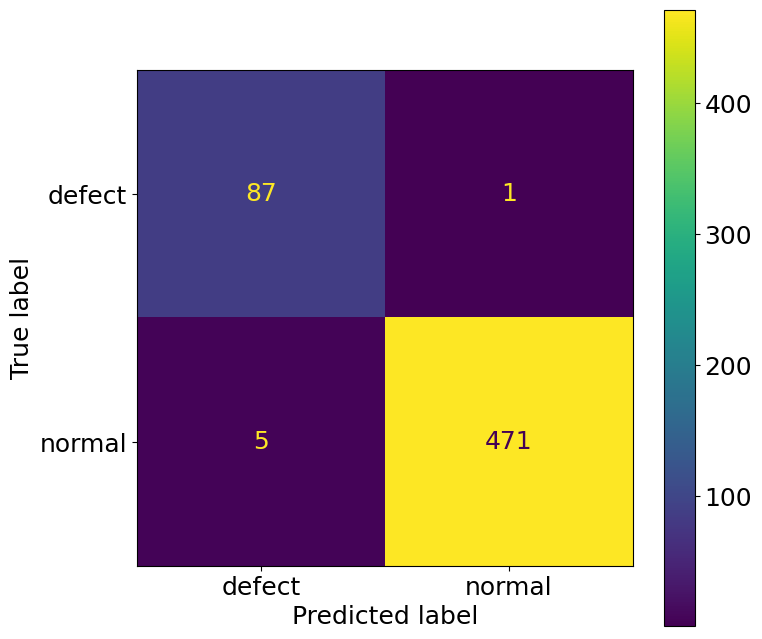

In [186]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

In [187]:
print(classification_report(targets, roundedPredictions))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        88
         1.0       1.00      0.99      0.99       476

    accuracy                           0.99       564
   macro avg       0.97      0.99      0.98       564
weighted avg       0.99      0.99      0.99       564



## roc no aug

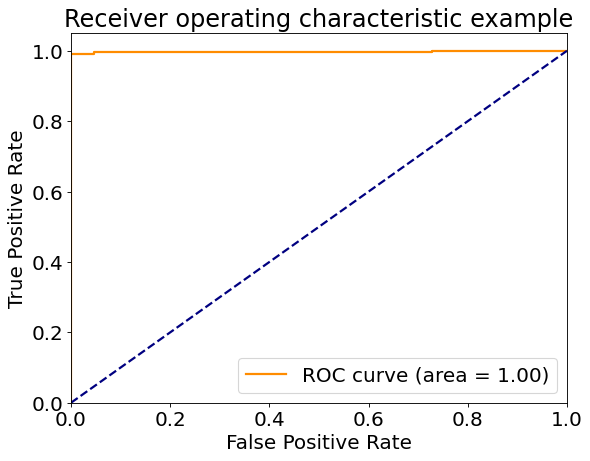

In [188]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [189]:
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
#tpr, fpr, thresholds = metrics.roc_curve(targets, predictions)
print(tpr)
print(len(tpr))
print("--------------------")
print(fpr)
print(len(fpr))
print("--------------------")
print(thresholds)
print("--------------------")
print(metrics.roc_auc_score(targets, predictions))
print("--------------------")
optimal_idx = np.argmax(tpr - fpr)
print(optimal_idx)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)


[0.         0.06722689 0.07563025 0.07773109 0.09033613 0.09243697
 0.11344538 0.1197479  0.12394958 0.1302521  0.13445378 0.14285714
 0.1512605  0.15546218 0.15966387 0.16176471 0.16596639 0.17016807
 0.17436975 0.17647059 0.18907563 0.19327731 0.19537815 0.19957983
 0.20378151 0.20798319 0.22058824 0.2289916  0.24369748 0.24789916
 0.27310924 0.27731092 0.27941176 0.28781513 0.29411765 0.29831933
 0.30672269 0.31092437 0.33403361 0.33823529 0.40546218 0.40966387
 0.47268908 0.47689076 0.4789916  0.48319328 0.48739496 0.49159664
 0.52310924 0.52731092 0.53151261 0.53571429 0.9894958  0.9894958
 0.99579832 0.99579832 0.99789916 0.99789916 1.         1.        ]
60
--------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        

## With opriumum Threshhold

In [190]:
predictions = model.predict(test_ds_NoShuf)

OldTargets = np.concatenate([targets for features, targets in test_ds_NoShuf], axis=0)
# print(targets)
targets = []
for num in OldTargets:
    targets.append(num[0])


In [191]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > optimal_threshold:
        p_temp = 1
    roundedPredictions.append(p_temp)

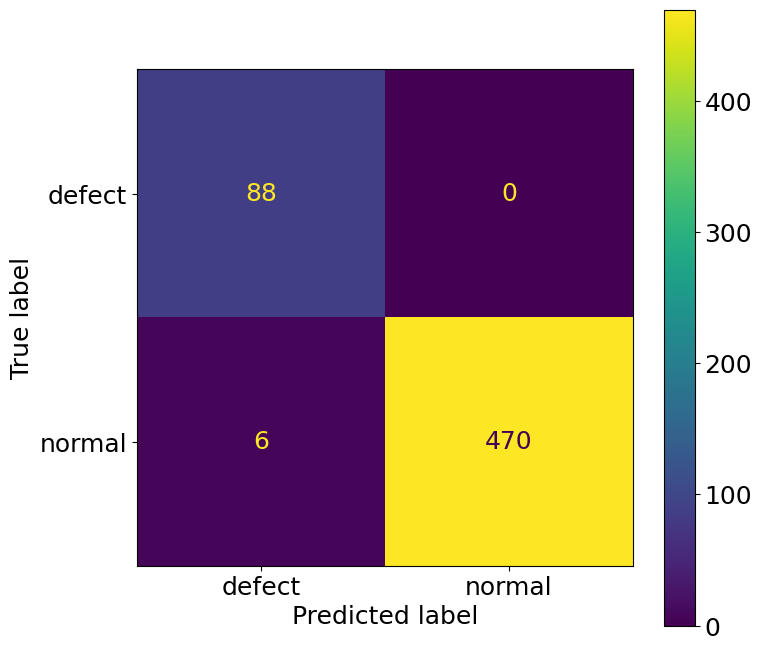

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        88
         1.0       1.00      0.99      0.99       476

    accuracy                           0.99       564
   macro avg       0.97      0.99      0.98       564
weighted avg       0.99      0.99      0.99       564



In [192]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

print(classification_report(targets, roundedPredictions))

## Using 0.15 Threshhold

In [193]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.15:
        p_temp = 1
    roundedPredictions.append(p_temp)

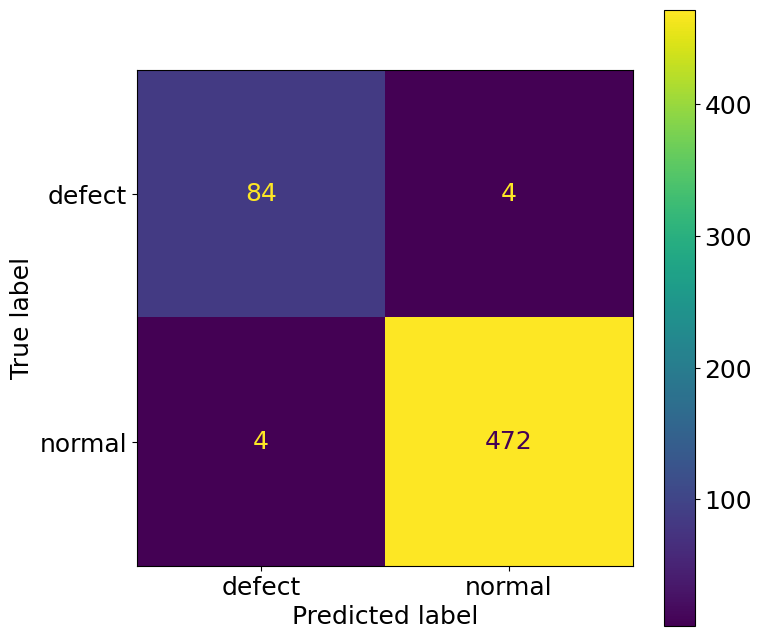

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        88
         1.0       0.99      0.99      0.99       476

    accuracy                           0.99       564
   macro avg       0.97      0.97      0.97       564
weighted avg       0.99      0.99      0.99       564



In [194]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

print(classification_report(targets, roundedPredictions))

## Testing on full images

### Person Tester Images

In [237]:
model = keras.models.load_model("inspection_model")


8
8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
with time per tile: 3.818272268748842


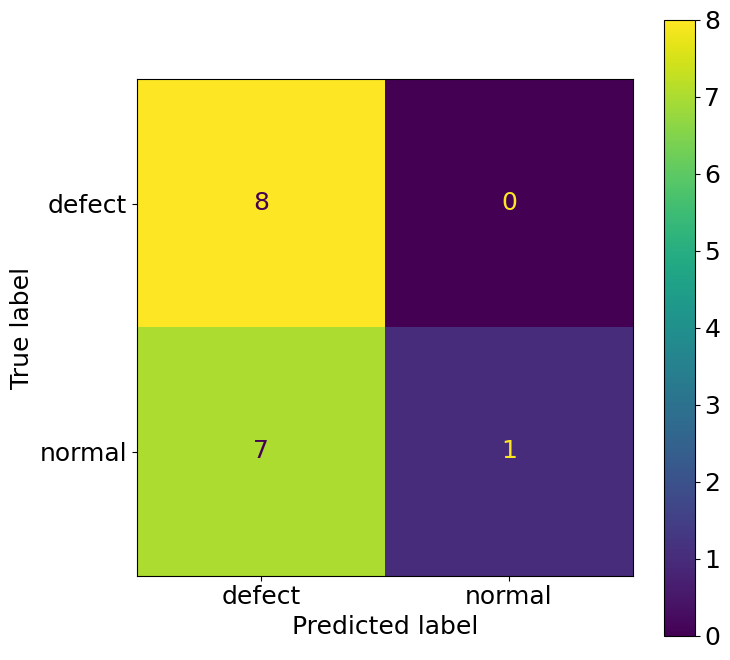

              precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.12      0.22         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



In [238]:


defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
    print('.')
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    print('.')
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))


f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))

#### Person Tester Images Strict

8
8


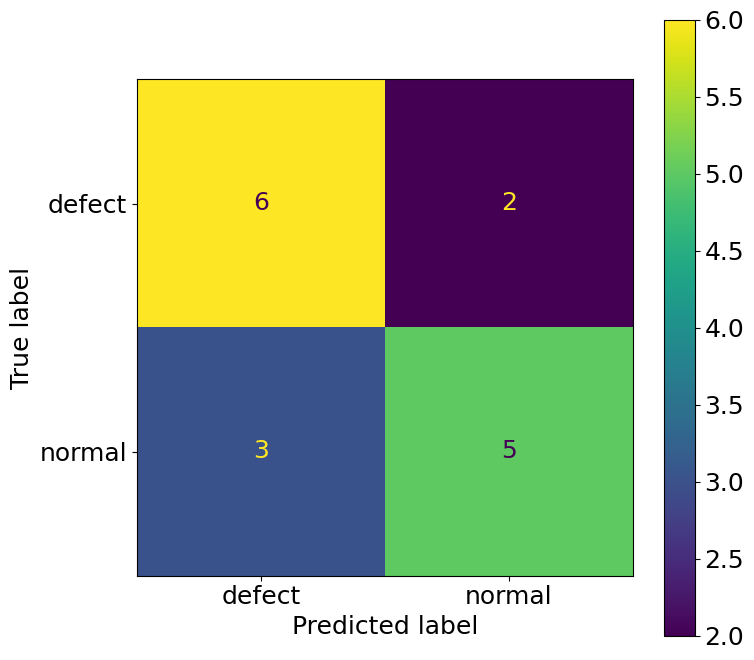

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.71      0.62      0.67         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16



In [239]:
defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))

### All Images

105
141
with time per tile: 3.9143099426810073


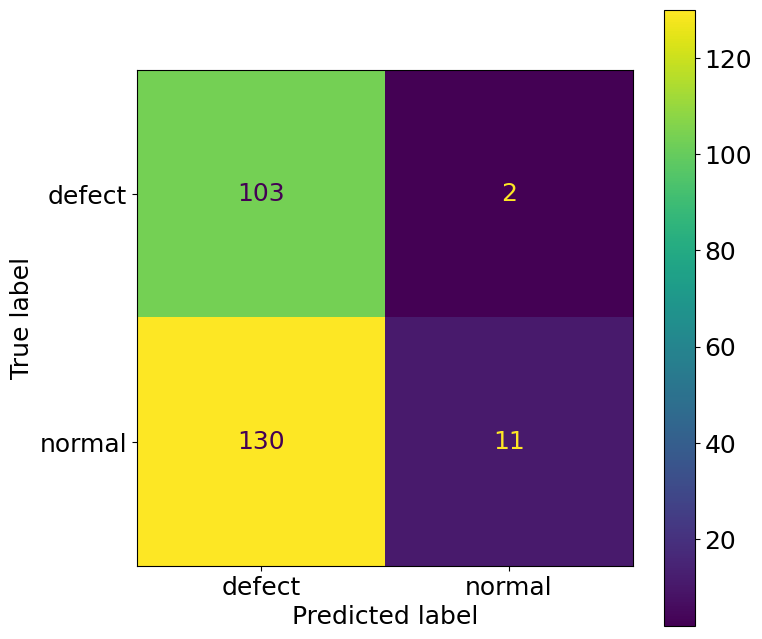

              precision    recall  f1-score   support

           0       0.44      0.98      0.61       105
           1       0.85      0.08      0.14       141

    accuracy                           0.46       246
   macro avg       0.64      0.53      0.38       246
weighted avg       0.67      0.46      0.34       246



In [240]:
defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))
    
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))

### All Images Strict

105
141


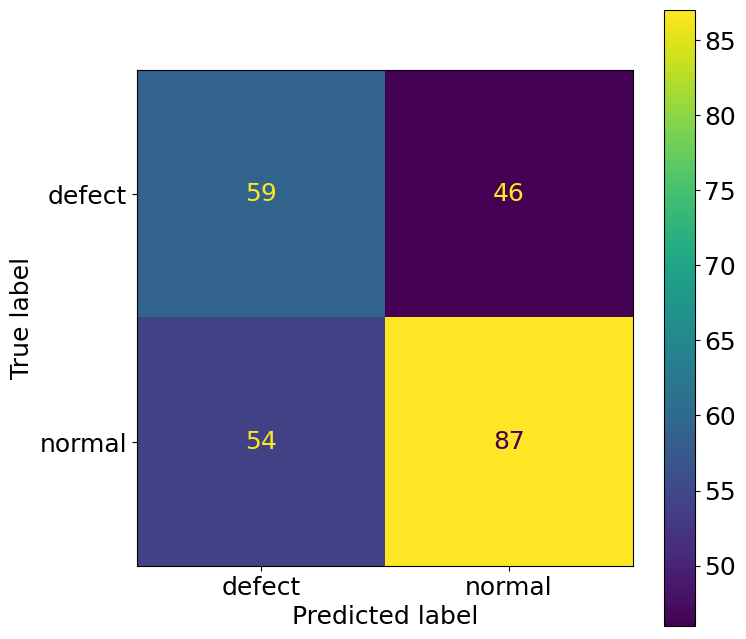

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       105
           1       0.65      0.62      0.64       141

    accuracy                           0.59       246
   macro avg       0.59      0.59      0.59       246
weighted avg       0.60      0.59      0.60       246



In [241]:
defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))

# Training with Augmentation 

In [216]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

In [217]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
#   layers.Dense(1)
])



In [218]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 sequential_8 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                 

In [219]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 20s 121ms/step - loss: 0.5462 - accuracy: 0.7464 - val_loss: 0.3920 - val_accuracy: 0.8521
Epoch 2/15
159/159 [==============================] - 23s 143ms/step - loss: 0.5085 - accuracy: 0.7658 - val_loss: 0.3994 - val_accuracy: 0.7859
Epoch 3/15
159/159 [==============================] - 22s 136ms/step - loss: 0.5085 - accuracy: 0.7642 - val_loss: 0.4595 - val_accuracy: 0.7601
Epoch 4/15
159/159 [==============================] - 20s 129ms/step - loss: 0.4975 - accuracy: 0.7628 - val_loss: 0.4438 - val_accuracy: 0.7715
Epoch 5/15
159/159 [==============================] - 19s 119ms/step - loss: 0.4983 - accuracy: 0.7715 - val_loss: 0.3886 - val_accuracy: 0.7994
Epoch 6/15
159/159 [==============================] - 19s 117ms/step - loss: 0.4869 - accuracy: 0.7686 - val_loss: 0.4035 - val_accuracy: 0.8004
Epoch 7/15
159/159 [==============================] - 20s 124ms/step - loss: 0.4779 - accuracy: 0.7684 - val_loss: 0.3807 - val_ac

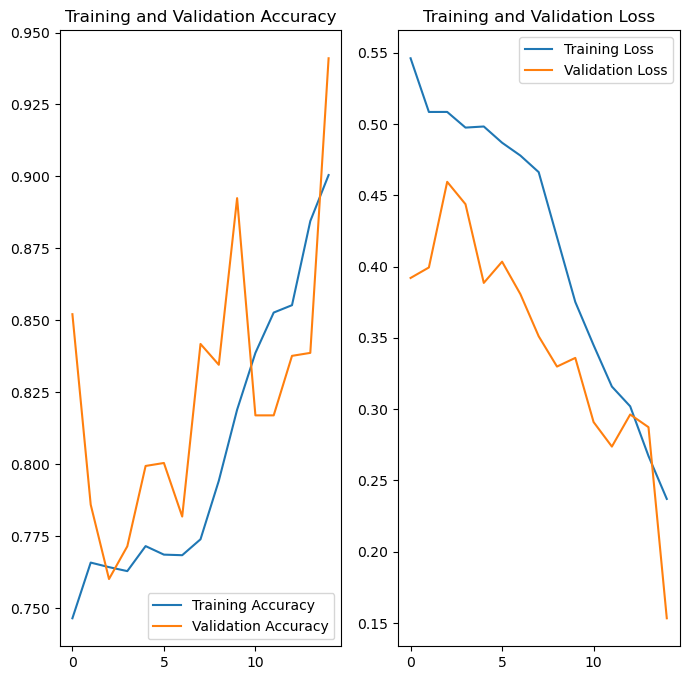

In [220]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.rcParams['font.size'] = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [221]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 1s 54ms/step - loss: 0.1328 - accuracy: 0.9486


{'loss': 0.13279031217098236, 'accuracy': 0.9485815763473511}

In [222]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 22s 137ms/step - loss: 0.2037 - accuracy: 0.9226 - val_loss: 0.1441 - val_accuracy: 0.9638
Epoch 2/15
159/159 [==============================] - 21s 134ms/step - loss: 0.1780 - accuracy: 0.9358 - val_loss: 0.1590 - val_accuracy: 0.9483
Epoch 3/15
159/159 [==============================] - 21s 132ms/step - loss: 0.1488 - accuracy: 0.9481 - val_loss: 0.1375 - val_accuracy: 0.9586
Epoch 4/15
159/159 [==============================] - 20s 125ms/step - loss: 0.1342 - accuracy: 0.9558 - val_loss: 0.1144 - val_accuracy: 0.9659
Epoch 5/15
159/159 [==============================] - 20s 127ms/step - loss: 0.1284 - accuracy: 0.9573 - val_loss: 0.1317 - val_accuracy: 0.9628
Epoch 6/15
159/159 [==============================] - 22s 136ms/step - loss: 0.1114 - accuracy: 0.9639 - val_loss: 0.1361 - val_accuracy: 0.9607
Epoch 7/15
159/159 [==============================] - 19s 121ms/step - loss: 0.1178 - accuracy: 0.9645 - val_loss: 0.1031 - val_ac

In [223]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 1s 54ms/step - loss: 0.0860 - accuracy: 0.9805


{'loss': 0.08604814857244492, 'accuracy': 0.9804964661598206}

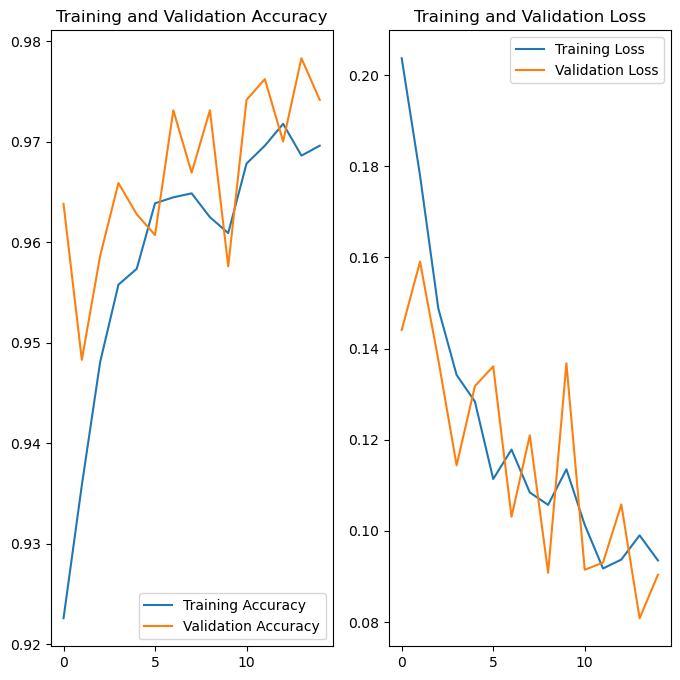

In [224]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.rcParams['font.size'] = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [225]:
model.save("inspection_model_aug")


INFO:tensorflow:Assets written to: inspection_model_aug\assets


In [242]:
model = keras.models.load_model("inspection_model_aug")


In [243]:
predictions = model.predict(test_ds_NoShuf)

OldTargets = np.concatenate([targets for features, targets in test_ds_NoShuf], axis=0)
# print(targets)
targets = []
for num in OldTargets:
    targets.append(num[0])

roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

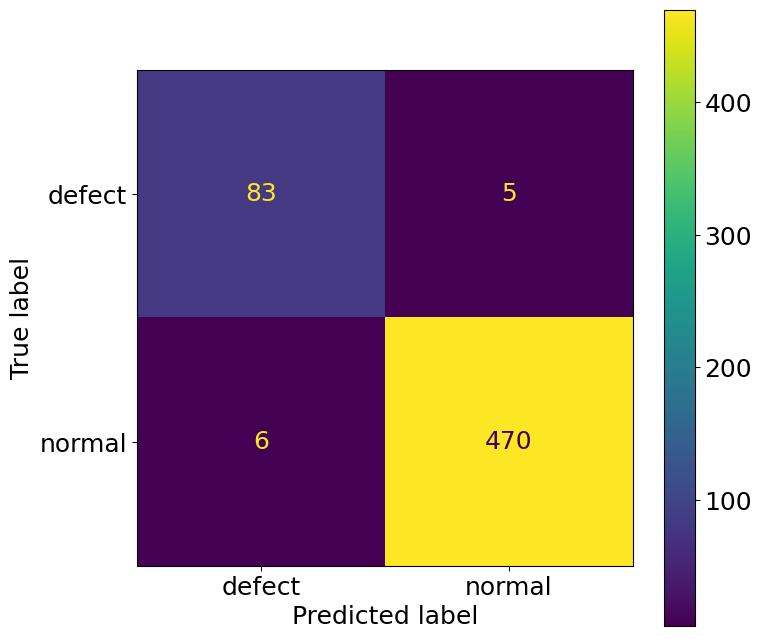

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94        88
         1.0       0.99      0.99      0.99       476

    accuracy                           0.98       564
   macro avg       0.96      0.97      0.96       564
weighted avg       0.98      0.98      0.98       564



In [244]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

print(classification_report(targets, roundedPredictions))

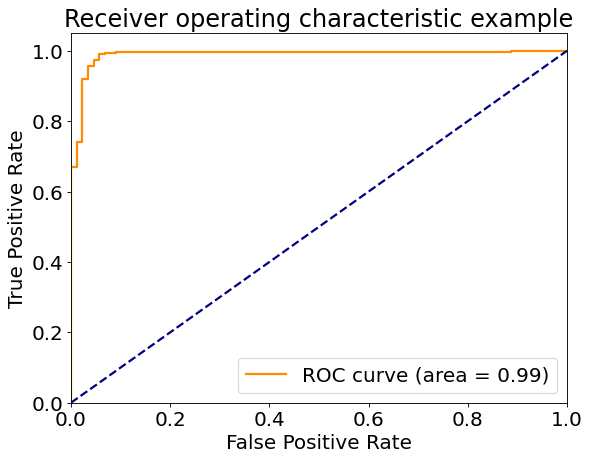

In [245]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [246]:
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
#tpr, fpr, thresholds = metrics.roc_curve(targets, predictions)
print(tpr)
print(len(tpr))
print("--------------------")
print(fpr)
print(len(fpr))
print("--------------------")
print(thresholds)
print("--------------------")
print(metrics.roc_auc_score(targets, predictions))
print("--------------------")
optimal_idx = np.argmax(tpr - fpr)
print(optimal_idx)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)


[0.         0.05672269 0.05882353 0.06932773 0.07142857 0.08403361
 0.20798319 0.21218487 0.63235294 0.63655462 0.67016807 0.67016807
 0.7394958  0.7394958  0.92016807 0.92016807 0.95798319 0.95798319
 0.97478992 0.97478992 0.99159664 0.99159664 0.99369748 0.99369748
 0.99579832 0.99579832 0.99789916 0.99789916 1.         1.        ]
30
--------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01136364
 0.01136364 0.02272727 0.02272727 0.03409091 0.03409091 0.04545455
 0.04545455 0.05681818 0.05681818 0.06818182 0.06818182 0.09090909
 0.09090909 0.10227273 0.10227273 0.88636364 0.88636364 1.        ]
30
--------------------
[2.0000000e+00 1.0000000e+00 9.9999982e-01 9.9999976e-01 9.9999964e-01
 9.9999869e-01 9.9923295e-01 9.9921620e-01 9.9093688e-01 9.9092865e-01
 9.8878533e-01 9.8878354e-01 9.8396295e-01 9.8394454e-01 8.9873493e-01
 8.9473087e-01 8.1148684e-01 8.1057966e-01 6.7895055e-01 6.6306949e-01
 3.2

## Using Best Threshhold

In [230]:
predictions = model.predict(test_ds_NoShuf)

OldTargets = np.concatenate([targets for features, targets in test_ds_NoShuf], axis=0)
# print(targets)
targets = []
for num in OldTargets:
    targets.append(num[0])


roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > optimal_threshold:
        p_temp = 1
    roundedPredictions.append(p_temp)

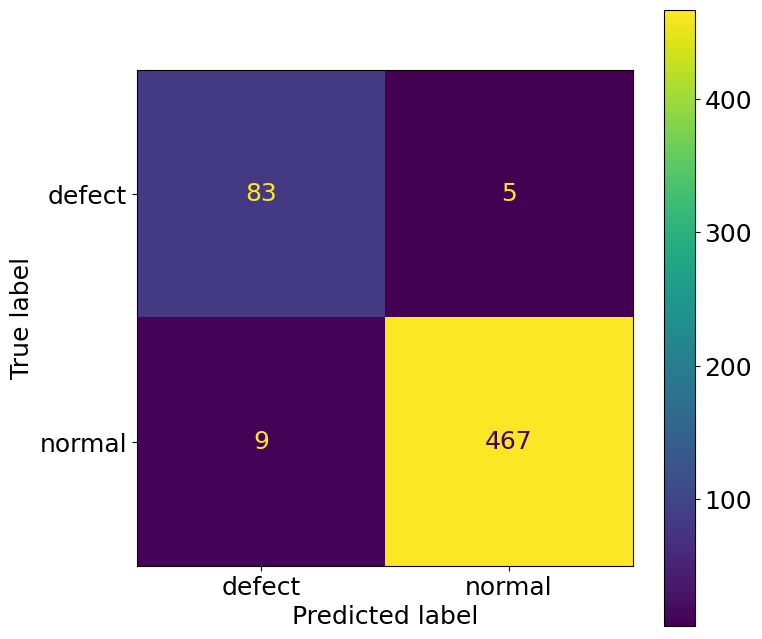

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92        88
         1.0       0.99      0.98      0.99       476

    accuracy                           0.98       564
   macro avg       0.95      0.96      0.95       564
weighted avg       0.98      0.98      0.98       564



In [231]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

print(classification_report(targets, roundedPredictions))

## Using 0.15 hreshhold

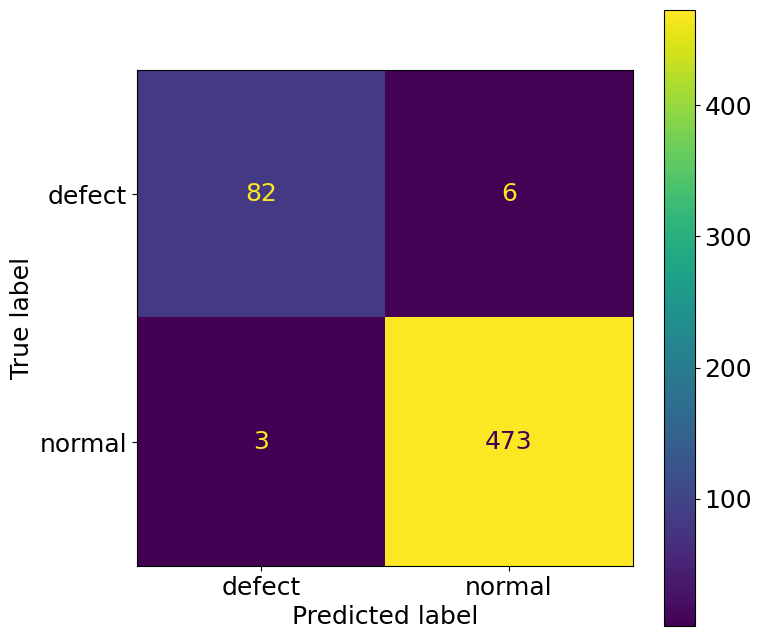

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95        88
         1.0       0.99      0.99      0.99       476

    accuracy                           0.98       564
   macro avg       0.98      0.96      0.97       564
weighted avg       0.98      0.98      0.98       564



In [232]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.15:
        p_temp = 1
    roundedPredictions.append(p_temp)
    
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

print(classification_report(targets, roundedPredictions))

## Testing on full images

### Person Tester Images

8
8
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
with time per tile: 4.73455308125267


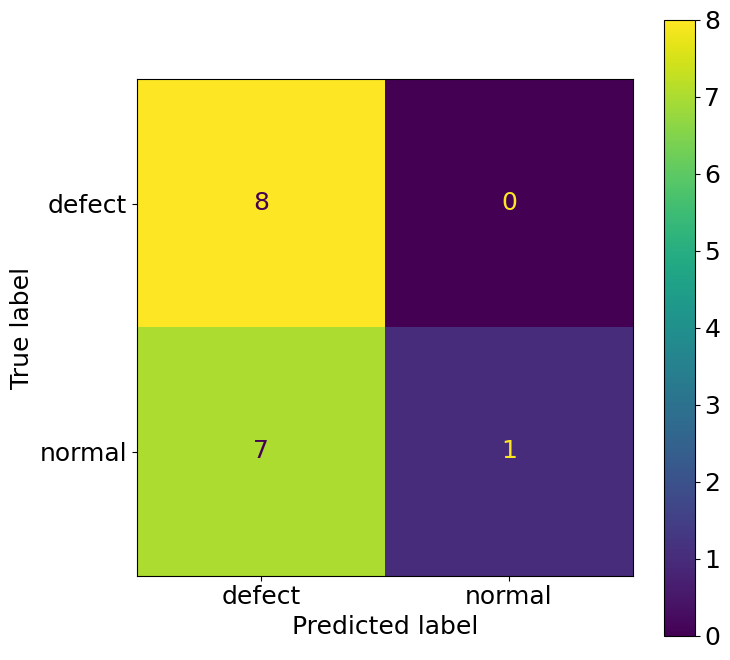

              precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.12      0.22         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



In [233]:


defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
    print('.')
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    print('.')
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))


f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))

### Person Tester Images Strict

8
8


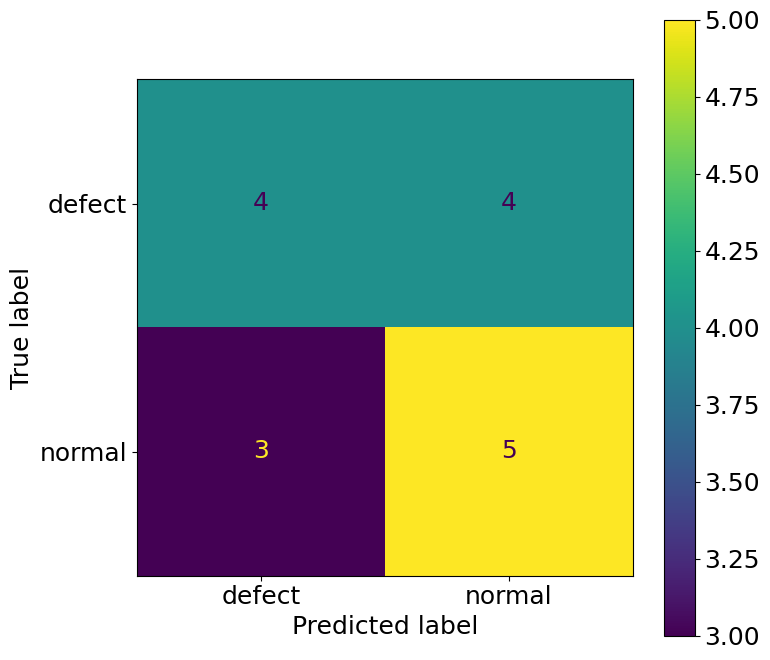

              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.56      0.62      0.59         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16



In [234]:
defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))

### All Images

105
141
with time per tile: 4.833867949997245


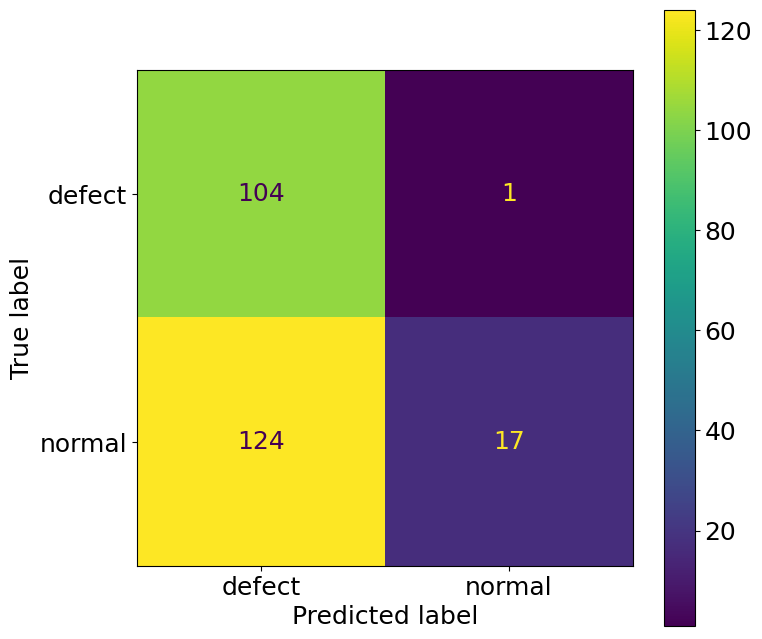

              precision    recall  f1-score   support

           0       0.46      0.99      0.62       105
           1       0.94      0.12      0.21       141

    accuracy                           0.49       246
   macro avg       0.70      0.56      0.42       246
weighted avg       0.74      0.49      0.39       246



In [235]:
defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))
    
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))

### All Images Strict

105
141


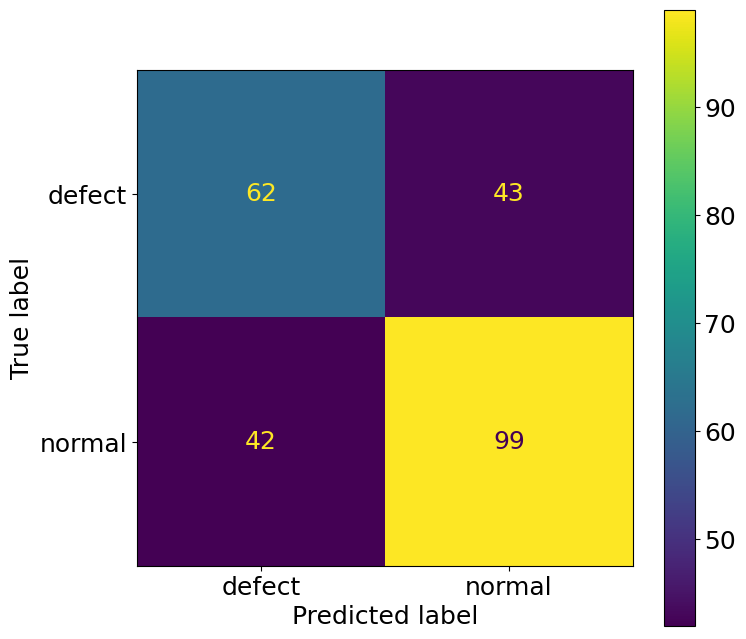

              precision    recall  f1-score   support

           0       0.60      0.59      0.59       105
           1       0.70      0.70      0.70       141

    accuracy                           0.65       246
   macro avg       0.65      0.65      0.65       246
weighted avg       0.65      0.65      0.65       246



In [236]:
defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

print(classification_report(targets, predictions))